# TODOs

**EDA**
- Plot all features over time

**Modelling Ideas**


- Visualize by performance by Store and Dept 
- Optimize models
- SHAP of best model
- Plot Explanations (Total and by Store)
- Compute interaction shap and plot stores interaction in a graph
- Estimate xgboost condidence invertals https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b 

- Optional: Understand and implement Autoregressive model

- Document steps

# Description

This is a notebook to aims to explore and solve the Walmart Kaggle problem described in 
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview.
In short, the problem consists in trying to predict weekly sales of 45 Walmart stores given the historical sales data, stores informations and external factors, such as temperature and fuel price. The given data corresponds to almost 3 years years of historical data, while the goal is to predict the sales over the following year.





# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
sns.set(style='whitegrid')

# EDA

## Loading Data

In [2]:
base_path = '../data/'

In [3]:
stores = pd.read_csv(base_path + 'stores.csv')
features = pd.read_csv(base_path + 'features.csv')
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')

## Dates

In [30]:
features.Date = pd.to_datetime(features.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

df_merged_train = train.merge(features.drop('IsHoliday',axis=1),on=['Store','Date'])\
                       .merge(stores,on=['Store']).sort_values('Date')

df_merged_test = test.merge(features.drop('IsHoliday',axis=1),on=['Store','Date'])\
                       .merge(stores,on=['Store']).sort_values('Date')

holidays = features[features.IsHoliday==True].Date.unique()

In [5]:
set(features.Date).difference(set(train.Date).union(test.Date)),\
(set(train.Date).union(test.Date)).difference(set(features.Date))

(set(), set())

In [6]:
train.Date.max(), test.Date.min()

(Timestamp('2012-10-26 00:00:00'), Timestamp('2012-11-02 00:00:00'))

## Stores
The first dataset we look at is the stores dataset. It consists of 3 columns, **Store**, which is just the store identifier, **Type** and **Size**. There are 3 types of Stores: A, B and C. Moreover, the sizes are related to the types, where A have greater sizes, followed by B and C.
There is a total of 45 stores.

In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
stores.Store.value_counts().value_counts()

1    45
Name: Store, dtype: int64

In [9]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


### Type

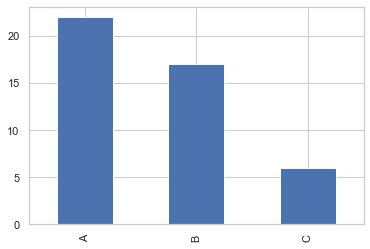

In [10]:
stores.Type.value_counts().plot.bar()

### Size

If we plot the Sizes distributions by store Types, we observe that they are obviously related.

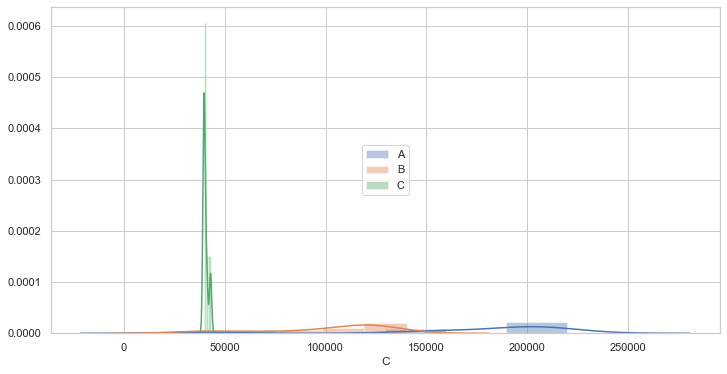

In [11]:
plt.figure(figsize=(12,6))
stores.groupby('Type').Size.apply(lambda x: sns.distplot(x,label=x.name))
plt.legend(loc='center')
plt.set_xlabel= 'bla'

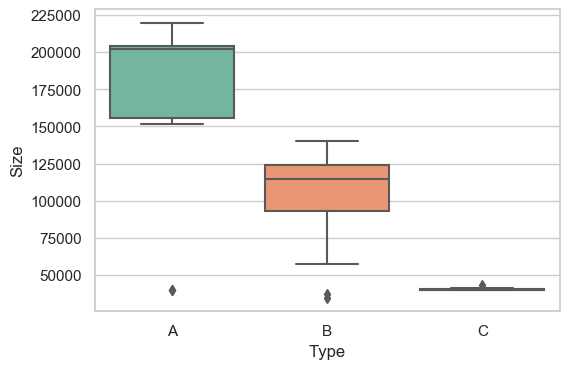

In [12]:
plt.figure(dpi=100)
sns.boxplot(x='Type', y='Size',data=stores, palette='Set2')

In [13]:
stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

Text(0, 0.5, '# Dept')

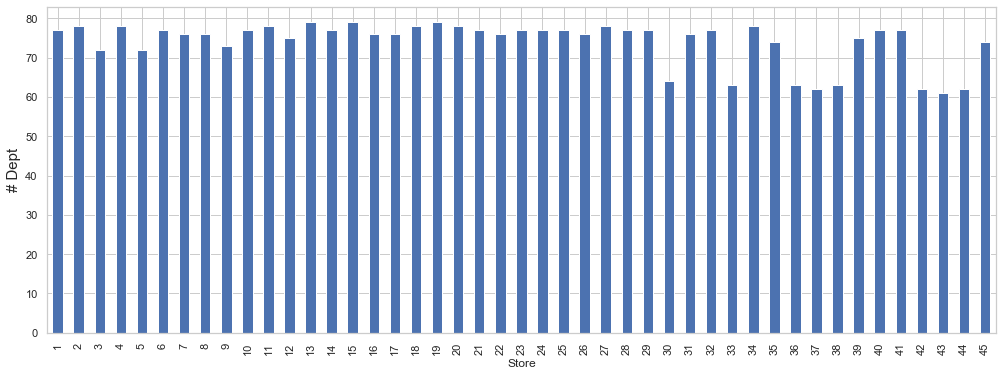

In [14]:
plt.figure(figsize=(17,6))
train.groupby('Store').Dept.nunique().plot.bar()
plt.ylabel('# Dept',fontsize=15)

## Features
As described in the page of the challenge, the features dataset consists of following columns:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

**Holidays**

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [15]:
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


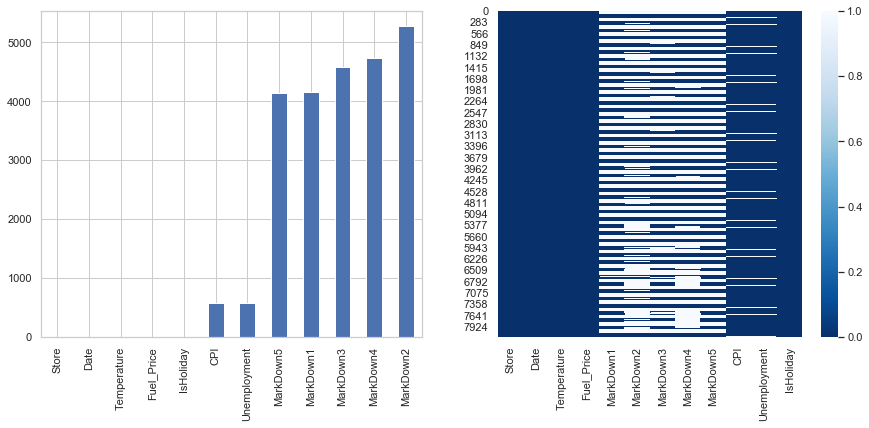

In [16]:
f, axs = plt.subplots(1,2,figsize=(15,6))
features.isna().sum().sort_values().plot.bar(ax=axs[0])
sns.heatmap(features.isna(),ax=axs[1], cmap='Blues_r')

In [17]:
(pd.crosstab(index=features.Store, columns = features.Date)>0).sum(axis=1).value_counts()

182    45
dtype: int64

In [19]:
def plot_time_evolution(df, col, group_col='Store',
                        date_col='Date', cmap='viridis', n_col=2,ax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(25,7))

    cmap = cm.get_cmap(cmap)
    norm = colors.Normalize(vmin=df[group_col].min(), vmax=df[group_col].max())

    _ = df.set_index(date_col)\
                .groupby(group_col)\
                [col]\
                .apply(lambda x: ax.plot(x,
                                          label=x.name, 
                                          c=cmap(norm(x.name)),
                                          alpha=0.7,
                                          **kwargs))

    ax.set_ylabel(col,fontsize=15)
    ax.legend(loc='upper right',ncol=n_col, bbox_to_anchor=(1.030, 1))

    _ = plt.xticks(rotation=90)
    
    return ax


def plot_holidays(holidays,ax=None,linewidth=3,linestyle='--',alpha=0.7):
    if ax is None:
        f, ax = plt.subplots(1,1)
    for d in holidays:
        ax.axvline(d, color='gray',linewidth=linewidth,linestyle=linestyle, alpha=alpha)
    return ax

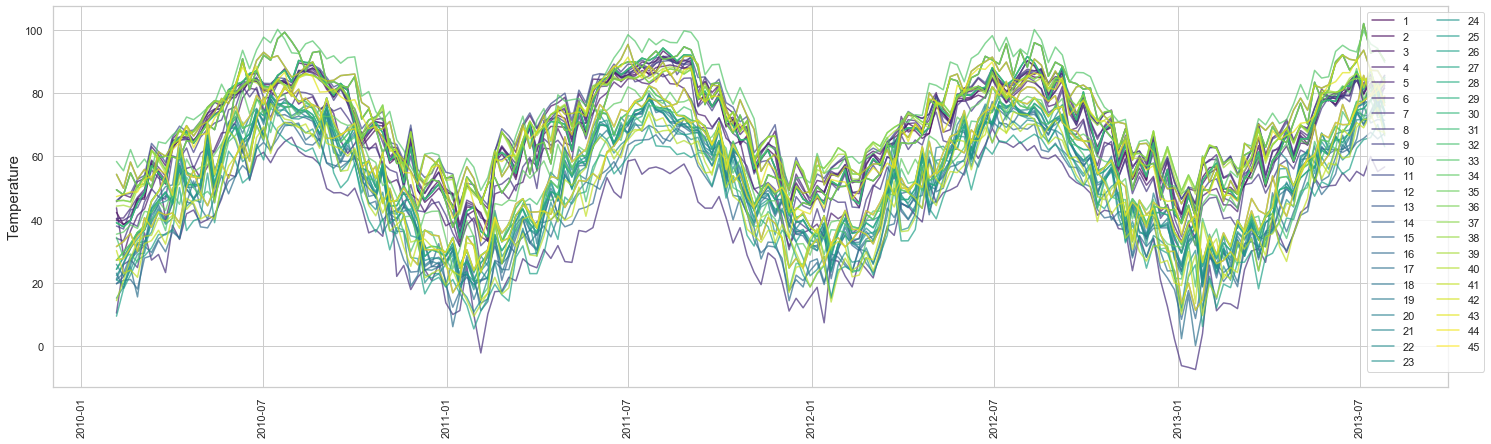

In [20]:
ax = plot_time_evolution(features,'Temperature')

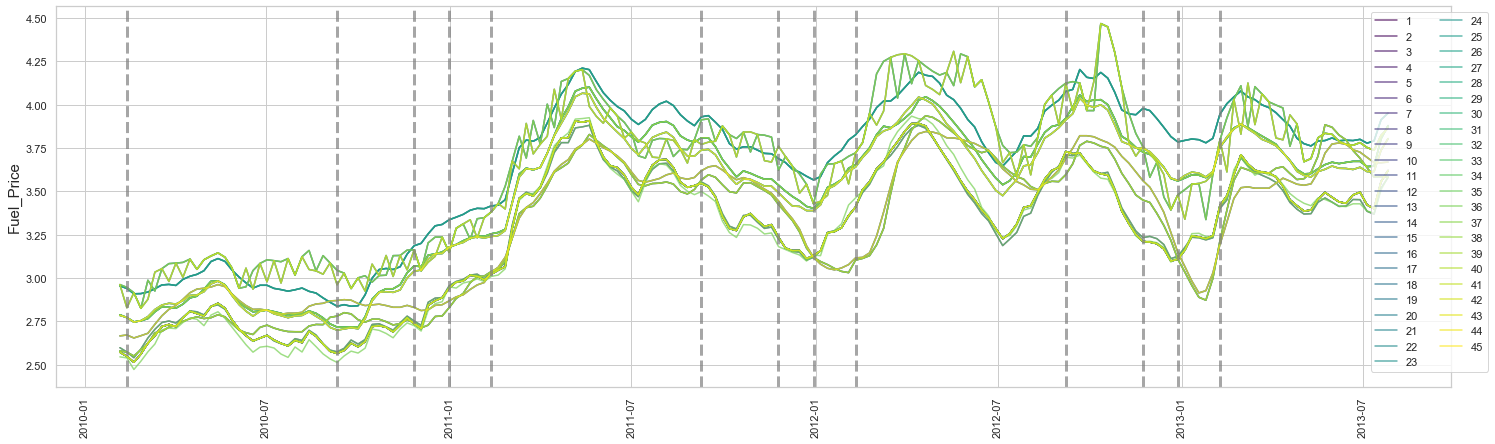

In [21]:
ax = plot_time_evolution(features,'Fuel_Price')
plot_holidays(holidays,ax=ax)

## Sales

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [22]:
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [23]:
train.Date.max()

Timestamp('2012-10-26 00:00:00')

### mean

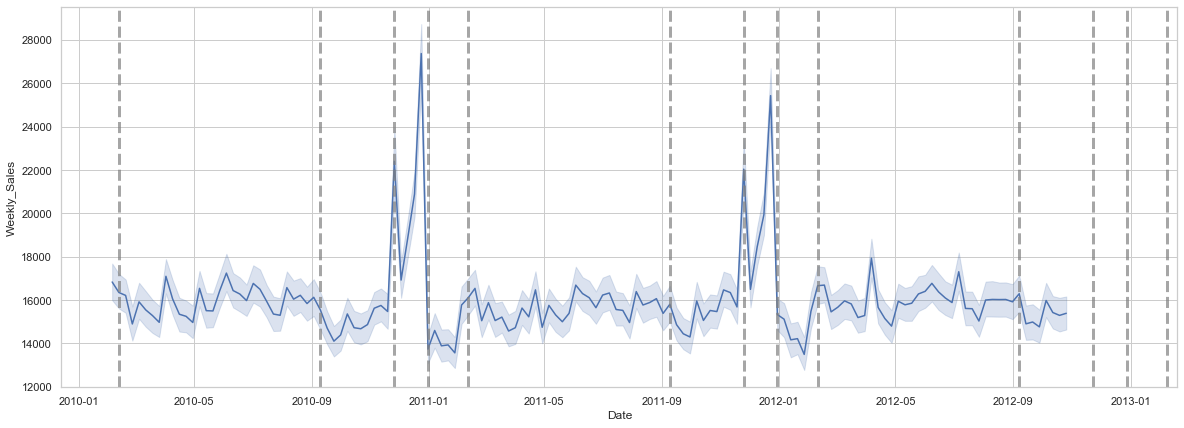

In [24]:
f, ax = plt.subplots(1,1,figsize=(20,7))
sns.lineplot(x='Date', y='Weekly_Sales',data=train,ax=ax)
plot_holidays(holidays,ax=ax)

### by Store

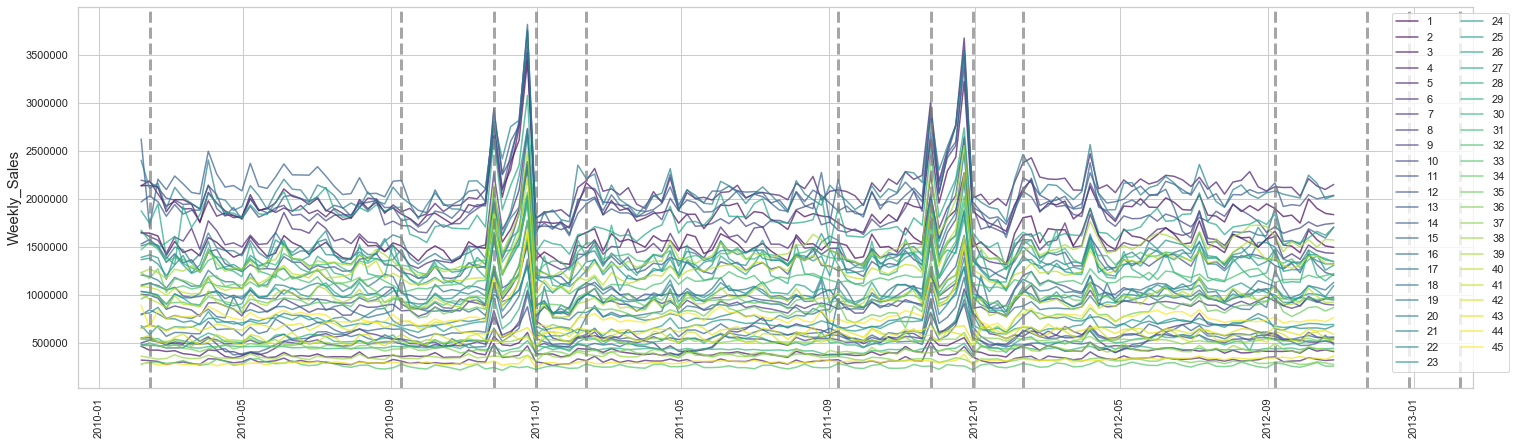

In [25]:
ax=plot_time_evolution(train.groupby(['Store','Date'])[['Weekly_Sales']]\
                       .sum().reset_index(),
                       'Weekly_Sales')
plot_holidays(holidays,ax=ax)

### by Departments

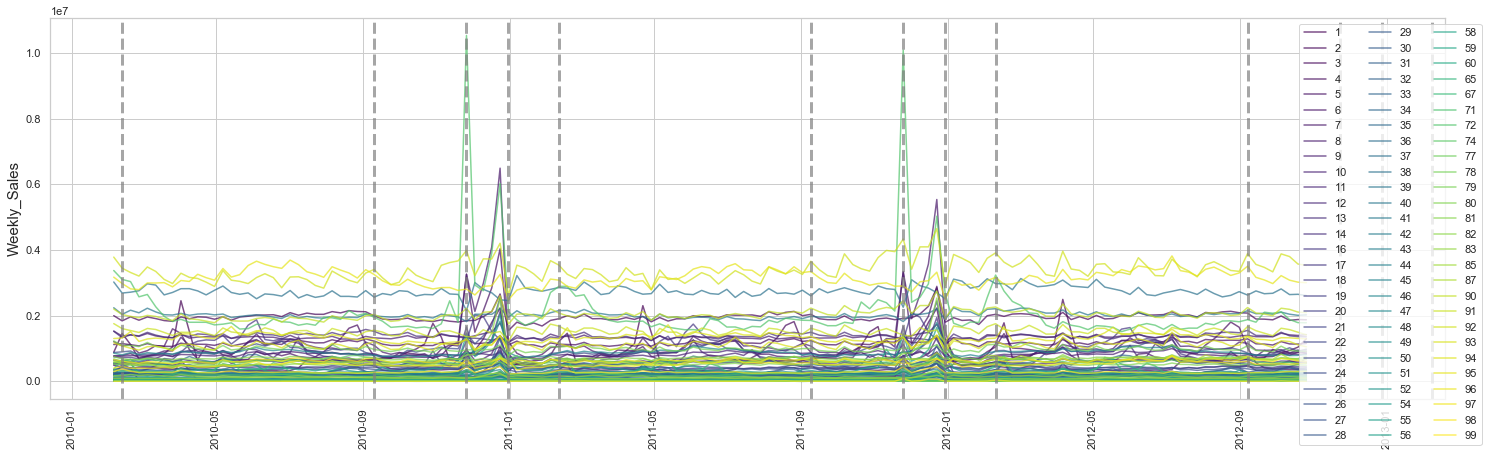

In [27]:
ax=plot_time_evolution(train.groupby(['Dept','Date'])[['Weekly_Sales']]\
                       .sum().reset_index()
                       ,'Weekly_Sales',group_col='Dept',n_col=3)
plot_holidays(holidays,ax=ax)

In [28]:
(train.groupby(['Store','Date']).Weekly_Sales.sum().unstack()>0).all().all()

True

### correlations

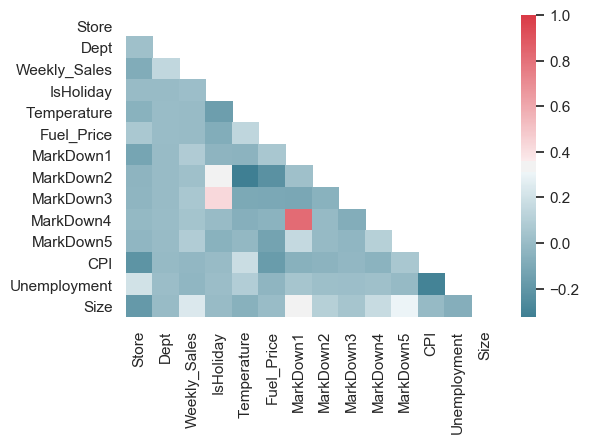

In [30]:
plt.figure(dpi=100)
corr = df_merged_train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,cmap=cmap)

## Pairplot

In [ ]:
%%time
sns.pairplot(df_merged_train.drop(['Date','Type', 'IsHoliday'],axis=1))

# Modelling

## Imports

In [11]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

import shap

## Metric

## Benchmarks

Benchmarks

1st rank submission error is 2300

val error: 2683

## Preprocess

In [8]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook

def get_weights(data, holiday_weight=5, default_weight=1):
    return data.IsHoliday.apply(lambda x: holiday_weight if x else default_weight)


class CustomColumnTransformer(ColumnTransformer):   
    
    def fit(self, df, y=None):
        return super().fit(df, y=y)
    
    def transform(self, df):
        data_transf = super().transform(df)
        columns = self.get_columns_names()
        return pd.DataFrame(data=data_transf.astype(float),columns=columns) 
    
    def fit_transform(self, df, y=None):
        data_transf = super().fit_transform(df, y=y)
        columns = self.get_columns_names()
        return pd.DataFrame(data=data_transf.astype(float),columns=columns)
        
    def get_columns_names(self):
        columns_names = []
        for name, transformer, cols in self.transformers_:
            if name!='drop':
                if name=='ohe':
                    cols = transformer.get_feature_names(cols)
                columns_names.append(cols)
        return [c for  subl in columns_names for c in subl ]

In [9]:
df_merged_train['day'] = df_merged_train.Date.dt.day
df_merged_train['month'] = df_merged_train.Date.dt.month

df_merged_test['day'] = df_merged_test.Date.dt.day
df_merged_test['month'] = df_merged_test.Date.dt.month

### Models definitions

In [13]:
categorical_cols = ['Type']
drop_cols = ['Date','Weekly_Sales']

numerical_cols = list(set(df_merged_train.columns).difference(set(drop_cols)\
                                                                .union(categorical_cols)))


customTransformer = CustomColumnTransformer([('ohe', OneHotEncoder(),categorical_cols),
                                             ('pass', 'passthrough', numerical_cols),
                                             ('drop', 'drop', drop_cols)])


dummy = Pipeline(steps = [('preprocess', customTransformer),
                           ('model', DummyRegressor())])


linear = Pipeline(steps=[('preprocess', customTransformer),
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                         ('scale', StandardScaler()),
                         ('model',BayesianRidge())])

tree = Pipeline(steps=[('preprocess', customTransformer),
                       ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                       ('model', DecisionTreeRegressor())])

xgb = Pipeline(steps=[('preprocess', customTransformer),
                      ('model', XGBRegressor())])

untrained_models = {'dummy': dummy,
                    'linear': linear,
                    'tree': tree,
                    'xgb': xgb}

## Split Data

In [14]:
date_split = pd.to_datetime('2011-09-01')

In [15]:
data_train = df_merged_train[df_merged_train.Date <= date_split]
data_val = df_merged_train[df_merged_train.Date > date_split]

y_train = data_train.Weekly_Sales
y_val = data_val.Weekly_Sales

## Test Fit

In [16]:
import inspect
import tqdm

In [172]:
%%time
fitted_models = {}

results = {'train': {},
           'val': {}}

weights = {'train': get_weights(data_train),
           'val': get_weights(data_val)}

for model_name, model in tqdm.notebook.tqdm(untrained_models.items()):
    uncertainty_available=False
    print('Fitting ' + model_name)
    model.fit(data_train,y=y_train)
    fitted_models[model_name] = model
    print('Predicting ' + model_name)
    
    if 'return_std' in inspect.getfullargspec(model.named_steps['model'].predict)[0]:
        y_pred_train, y_std_train = model.predict(data_train,return_std=True)
        y_pred_val, y_std_val =  model.predict(data_val,return_std=True)
        uncertainty_available = True        
    else:
        y_pred_train = model.predict(data_train)
        y_pred_val = model.predict(data_val)
        
        
    results['train'].update({model_name:{'preds': y_pred_train,
                                    'wmae': mean_absolute_error(y_train,
                                                                y_pred_train, 
                                                                sample_weight=weights_train)}})
                        
    
    results['val'].update({model_name:{'preds': y_pred_val,
                                       'wmae': mean_absolute_error(y_val,
                                                                y_pred_val, 
                                                                sample_weight=weights_val)}})
    if uncertainty_available:
        results['train'][model_name].update({'std': y_std_train})
        results['val'][model_name].update({'std': y_std_val})

Fitting dummy
Predicting dummy
Fitting linear
Predicting linear
Fitting tree
Predicting tree
Fitting xgb
Predicting xgb

CPU times: user 53.4 s, sys: 1.05 s, total: 54.5 s
Wall time: 12.4 s


CPU times: user 13.9 s, sys: 145 ms, total: 14 s
Wall time: 14.1 s


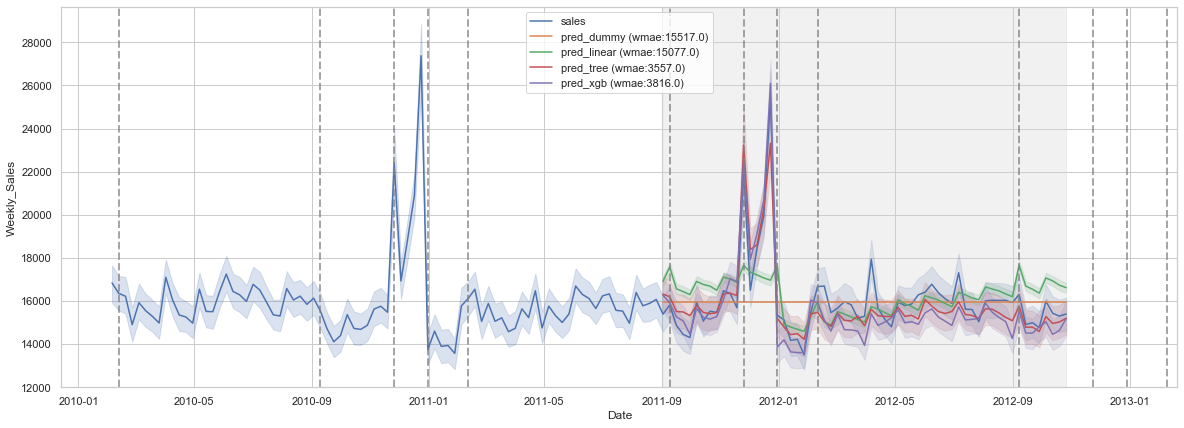

In [194]:
%%time
f, ax = plt.subplots(1,1,figsize=(20,7))

sns.lineplot(x='Date',y='Weekly_Sales',data=train,ax=ax,label='sales')

for model_name, model in fitted_models.items():
    col_pred = 'pred_' + model_name 
    label = col_pred + ' (wmae:' + str(np.round(results['val'][model_name]['wmae'],0)) + ')'
    
    sns.lineplot(x=data_val.Date,
                 y=results['val'][model_name]['preds'],
                 label=label,
                 ax=ax)

ax.legend(loc='upper center')
ax.axvspan(data_val.Date.min(), data_val.Date.max(), color = 'lightgray', alpha=0.30)
plot_holidays(holidays, ax=ax, linewidth=2)

,train,val
dummy,1.515677e+04,15516.582768
linear,1.462308e+04,15076.617122
tree,1.368866e-18,3556.895065
xgb,2.936039e+03,3815.758308


<Figure size 600x400 with 0 Axes>

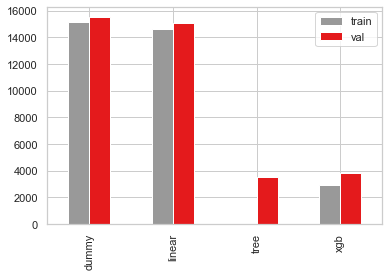

In [237]:
plt.figure(dpi=100)
pd.DataFrame(results).applymap(lambda x: x['wmae']).plot.bar(cmap='Set1_r'),
pd.DataFrame(results).applymap(lambda x: x['wmae'])

## Optimization

In [22]:
from sklearn.model_selection import TimeSeriesSplit

In [319]:
params = {
    'linear': {'model__alpha_1': [1e-6, 1, 2, 3],
               'model__alpha_2': [1e-6, 0.1, 1, 5],
               'model__lambda_1': [1e-6, 1, 2, 3],
               'model__lambda_2': [1e-6, 0.1, 1, 5]},
    
    'tree': {'model__criterion': ['mae', 'mse'],
             'model__max_depth': [2, 5, 8],
             'model__ccp_alpha': [0.1,1, 10]},
    
    'xgb': {'model__num_estimators': [5, 20, 100, 150],
            'model__max_depth': [2, 5, 8],
            'model__reg_alpha': [0.01,0.1,1,10],
            'model__early_stopping_rounds': [5,10]}
}

In [288]:
import pickle
cv = TimeSeriesSplit(n_splits=5).split(data_train)

In [321]:
%%time
results_opt={}
for model_name, model in tqdm.notebook.tqdm(untrained_models.items()):      
    if model_name!='dummy':
        model_opt = RandomizedSearchCV(untrained_models[model_name],
                                       params[model_name],
                                       n_jobs=20,
                                       n_iter=15,
                                       scoring='neg_mean_absolute_error',
                                       verbose=-1)  
        print('Optimizing ' + model_name + '...')
        model_opt.fit(data_train,y_train)
        
        y_pred = model_opt.best_estimator_.predict(data_val)
        wmae = mean_absolute_error(y_val, y_pred, sample_weight=weights_val)

        results_opt[model_name] = {'cv_results': model_opt.cv_results_,
                                   'y_pred_val': y_pred,
                                   'wmae': wmae}
    


Optimizing linear...


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:   16.0s
[Parallel(n_jobs=20)]: Done  75 out of  75 | elapsed:   24.2s finished


Optimizing tree...


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed: 113.2min
[Parallel(n_jobs=20)]: Done  75 out of  75 | elapsed: 213.2min finished


Optimizing xgb...


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:  3.2min
[Parallel(n_jobs=20)]: Done  75 out of  75 | elapsed:  5.2min finished


[21:13:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.





NameError: name 'results_ope' is not defined

In [322]:
 pickle.dump(results_opt, open('../results/results_opt.pickle','wb'))

# Model Explanation

In [ ]:
shap.TreeExplainer

## Interactions between stores

# Conclusion - summary and possible improvements